In [1]:
import time
import math
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from google.colab import files

#importing the file of sequences
uploaded_files = files.upload()
fname = open('sequences16.csv', 'r')

Saving sequences16.csv to sequences16.csv


In [2]:
sx, sy = np.loadtxt(fname,
                    delimiter=',',
                    usecols=(0,1),
                    unpack=True,
                    dtype=str
                    )
N=len(sy)
Ls=len(sx[0])

perc_train=0.7
N_train= int(N*perc_train)
N_test = N-N_train

print('Original dataset composition:\n')
print(f'\ndata: {N}\ntrain: {N_train}\ntest: {N_test}')

Original dataset composition:


data: 3000
train: 2100
test: 900


In [3]:
#one hot encoding
Q = ['A', 'C', 'G', 'T']
Nc=4
onehc={Q[i]: i for i in range(Nc)}

y = sy.astype(int)
L = Ls*Nc

x = np.zeros((N, L))

for n in range(N):
    for i in range(Ls):
        x[n][i*4 + onehc[sx[n][i]]] = 1 

## Point 1

In [4]:
x_train, y_train = x[:N_train], y[:N_train]
x_test, y_test = x[N_train:], y[N_train:]

score_train = y_train.sum()/len(y_train)
score_test = y_test.sum()/len(y_test)
print(score_train, score_test)

0.24714285714285714 0.24444444444444444


In [5]:
np.random.seed(123)

model = Sequential()
model.add(Dense(L, input_shape=(L,), activation='relu'))
model.add(Dense(L/2, activation='relu'))
model.add(Dense(L/4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


29/29 [==============================] - 0s 1ms/step - loss: 0.9807 - accuracy: 0.7989
Test loss: 0.9807488322257996
Test accuracy: 0.7988888621330261


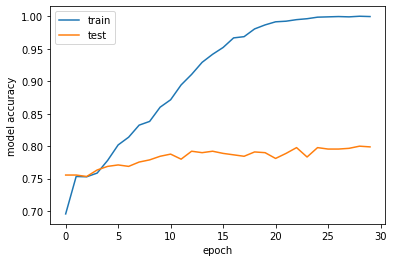

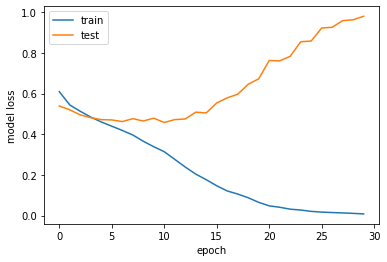

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='ADAM',
              metrics=['accuracy'])

fit = model.fit(x_train, y_train,
                epochs = 30,
                batch_size = 50,
                validation_data = (x_test, y_test),
                shuffle = True,
                verbose = 0
               )

score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Data augmentation

In [7]:
#one hot encoding

sx_train = sx[:N_train]
sx_train_augm = []
y_train_augm = []

def shifting(x, positions, label):
    '''
    
    function that shifts our srings
    
    '''
    shifted_x = []
    shifted_y =  []
    
    shifted_x.append(x)
    shifted_y.append(label)
    
    temp = x
    
    for j in range(positions):
        temp = temp[-1:]+temp[:-1]
        shifted_x.append(temp)
        shifted_y.append(label)
             
    return shifted_x, shifted_y
          
position = 15       

for i in range(len(sx_train)):
    sx_train_augm += shifting(sx_train[i], position, y_train[i])[0]
    y_train_augm += shifting(sx_train[i], position, y_train[i])[1]   

In [8]:
N_augm = len(sx_train_augm)

Q = ['A', 'C', 'G', 'T']
Nc=4
onehc={Q[i]: i for i in range(Nc)}

y = sy.astype(int)
L = Ls*Nc

x_train_augm = np.zeros((N_augm, L))

for n in range(N_augm):
    for i in range(Ls):
        x_train_augm[n][i*4 + onehc[sx_train_augm[n][i]]] = 1

In [9]:
np.random.seed(123)

model_aug = Sequential()
model_aug.add(Dense(L, input_shape=(L,), activation='relu'))
model_aug.add(Dense(L/2, activation='relu'))
model_aug.add(Dense(L/4, activation='relu'))
model_aug.add(Dropout(0.2))
model_aug.add(Dense(1, activation='sigmoid'))

print(model_aug.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model_aug.compile(loss='binary_crossentropy',
                  optimizer='ADAM',
                  metrics=['accuracy']
                  )


fit_aug = model_aug.fit(np.asarray(x_train_augm),
                        np.asarray(y_train_augm),
                        epochs=30,
                        batch_size=500,
                        validation_data=(x_test, y_test),
                        shuffle=True,
                        verbose = 0                    
                        )

score = model_aug.evaluate(x_test, y_test, verbose=1)

# print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])

29/29 [==============================] - 0s 1ms/step - loss: 0.2808 - accuracy: 0.8956
Test loss: 0.2807908356189728
Test accuracy: 0.8955555558204651


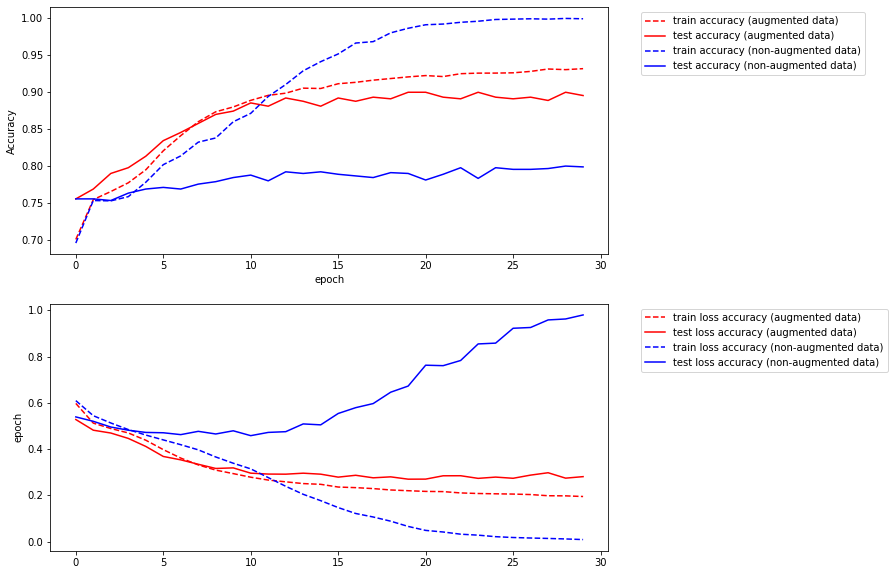

In [11]:
# look into training history
plt, ax = plt.subplots(2,1,figsize=(10,10))
#accuracy
ax[0].plot(fit_aug.history['accuracy'],
         label='train accuracy (augmented data)',
         c='red',
         ls='--'
        )
ax[0].plot(fit_aug.history['val_accuracy'],
         label='test accuracy (augmented data)',
         c='red'
        )
ax[0].plot(fit.history['accuracy'],
         label='train accuracy (non-augmented data)',
         c='blue',
         ls='--'
        )
ax[0].plot(fit.history['val_accuracy'],
         label='test accuracy (non-augmented data)',
         c='blue'
         )
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(bbox_to_anchor=(1.05, 1))

#loss
ax[1].plot(fit_aug.history['loss'],
         label='train loss accuracy (augmented data)',
         c='red',
         ls='--'
         )
ax[1].plot(fit_aug.history['val_loss'],
           label='test loss accuracy (augmented data)',
           c='red'
           )
ax[1].plot(fit.history['loss'],
           label='train loss accuracy (non-augmented data)',
           c='blue',
           ls='--'
           )
ax[1].plot(fit.history['val_loss'],
           label='test loss accuracy (non-augmented data)',
           c='blue'
           )
ax[1].set_ylabel('Loss')
ax[1].set_ylabel('epoch')
ax[1].legend(bbox_to_anchor=(1.05, 1))

plt.show()

As we can notice from the plot just above, enlarging the dataset helps us to avoid overfitting in 30 epochs and to achieve a higher test accuracy. When enlarging the dataset, the prevalent effect is the increase in the number of useful training samples, rather than the introduction of bad ones (label mistakenly associated). 


## Grid Search

In [12]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='RMSprop', activation='relu', dropout_rate=0.2):
    # create model
    model_grid = Sequential()
    model_grid.add(Dense(L, input_shape=(L,), activation=activation))
    model_grid.add(Dense(L/2, activation=activation))
    model_grid.add(Dropout(dropout_rate))
    model_grid.add(Dense(1, activation=activation))

    model_grid.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )
    return model_grid
 
# create model 
model_gridsearch = KerasClassifier(build_fn=create_model, 
                        epochs=30, 
                        batch_size=800,
                        verbose=0)

# list of allowed optional arguments for the optimizer, see compile_model()
optimizer = ['SGD', 'RMSprop', 'Adam']
activation = ['relu', 'elu', 'sigmoid', 'tanh']
dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]

# define parameter dictionary
param_grid = dict(optimizer     = optimizer,
                  dropout_rate  = dropout_rate,
                  activation    = activation
                 )
# call scikit grid search module
grid = GridSearchCV(estimator = model_gridsearch,
                    param_grid = param_grid,
                    n_jobs = 1,
                    cv = 4,
                    verbose=0)
grid_result = grid.fit(np.asarray(x_train_augm),np.asarray(y_train_augm))

In [13]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.840030 using {'activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'RMSprop'}
0.629018 (0.220523) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'SGD'}
0.836399 (0.008074) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'RMSprop'}
0.789851 (0.017333) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'Adam'}
0.756071 (0.012330) with: {'activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'SGD'}
0.840030 (0.010359) with: {'activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'RMSprop'}
0.788095 (0.017588) with: {'activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'Adam'}
0.753155 (0.012070) with: {'activation': 'relu', 'dropout_rate': 0.3, 'optimizer': 'SGD'}
0.828780 (0.011938) with: {'activation': 'relu', 'dropout_rate': 0.3, 'optimizer': 'RMSprop'}
0.787470 (0.023982) with: {'activation': 'relu', 'dropout_rate': 0.3, 'optimizer': 'Adam'}
0.752827 (0.012216) with: {'activation': 'relu', 'dropout_rate': 0.4, 'optimizer': 'SG

## Rescale analysis

In [21]:
mean = x_train_augm.mean()
stdev = x_train_augm.std()

x_train_augm = (x_train_augm - mean)/stdev #TO CHECK!
print('mean', x_train_augm.mean())
print('stdev', x_train_augm.std())

mean -3.026405804203621e-17
stdev 1.0


In [22]:
final_model = create_model(optimizer='RMSprop', activation='relu', dropout_rate=0.2) #Best model from GridSearch
print(final_model.summary())

Model: "sequential_245"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_738 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_739 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_245 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_740 (Dense)            (None, 1)                 33        
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________
None



Test loss: 3.770543336868286
Test accuracy: 0.7555555701255798


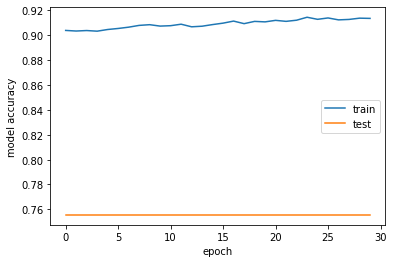

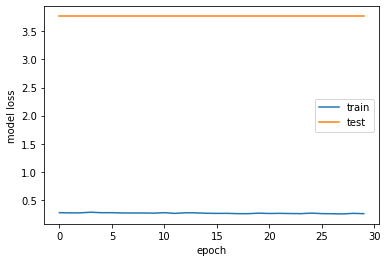

In [26]:
fit_final_model = final_model.fit(np.asarray(x_train_augm), np.asarray(y_train_augm),
                                  epochs = 30,
                                  batch_size=800,
                                  validation_data = (x_test, y_test),
                                  shuffle = True,
                                  verbose = 0                          
                                  )

score = final_model.evaluate(x_test, y_test, verbose=0)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# accuracy
plt.plot(fit_final_model.history['accuracy'])
plt.plot(fit_final_model.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# loss
plt.plot(fit_final_model.history['loss'])
plt.plot(fit_final_model.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Appendix

In [17]:
# Trials with different shifts

In [18]:
shifting_list = [3, 7, 11, 15]

def shifting(x, positions, label):
    #function that shifts our strings
    shifted_x = []
    shifted_y =  []
    
    shifted_x.append(x)
    shifted_y.append(label)
    
    temp = x
    
    for j in range(positions):
        temp = temp[-1:]+temp[:-1]
        shifted_x.append(temp)
        shifted_y.append(label)
             
    return shifted_x, shifted_y

for shift in shifting_list:
    
    temp_x = []
    temp_y = []
    
    for i in range(len(sx_train)):
        temp_x += shifting(sx_train[i], shift, y_train[i])[0]
        temp_y += shifting(sx_train[i], shift, y_train[i])[1] 
    if shift == 3:
        sx_train_4 = temp_x
        y_train_4 = temp_y 
    if shift == 7:
        sx_train_8 = temp_x
        y_train_8  = temp_y 
    if shift == 11:
        sx_train_12 = temp_x
        y_train_12 = temp_y 
    if shift == 15:
        sx_train_16 = temp_x
        y_train_16 = temp_y 

In [19]:
np.random.seed(123)

model_shift = Sequential()
model_shift.add(Dense(L, input_shape=(L,), activation='relu'))
model_shift.add(Dense(L/2, activation='relu'))
model_shift.add(Dense(L/4, activation='relu'))
model_shift.add(Dropout(0.2))
model_shift.add(Dense(1, activation='sigmoid'))

print(model_shift.summary())

Model: "sequential_244"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_734 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_735 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_736 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_244 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_737 (Dense)            (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
fig, ax = plt.subplots(2,1, figsize=(10,10))

model_shift.compile(loss='binary_crossentropy',
                    optimizer='ADAM',
                    metrics=['accuracy'])

shifted_x_list = [sx_train_4, sx_train_8, sx_train_12, sx_train_16]
shifted_y_list = [y_train_4, y_train_8, y_train_12, y_train_16]
batch_size = [100, 300, 500, 800]
color = ['red', 'blue', 'green', 'orange']


for i in range(len(shifted_x_list)):
    
    x_train = np.zeros((len(shifted_x_list[i]), L))
    
    for j in range(len(shifted_x_list[i])):
        for k in range(Ls):
            x_train[j][k*4 + onehc[shifted_x_list[i][j][k]]] = 1 #for every step in string you jump of 4 i the autoencpding

    fit_shift = model_shift.fit(np.asarray(x_train), np.asarray(shifted_y_list[i]),
                   epochs=30, batch_size=batch_size[i],
                   validation_data=(x_test, y_test),
                   shuffle=True, #changes composition of mini batch                                
                   verbose=0)

    score = model_shift.evaluate(x_test, y_test, verbose=0)

    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    final = str(shifting_list[i]+1) + ' shift'
    final_2 = str(shifting_list[i]+1) + ' shift'
    ax[0].plot(fit_shift.history['val_accuracy'],
               label=final,
               c=color[i]
               )
    ax[0].set_title('Accuracy on different datasets vs epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(bbox_to_anchor=(1.05, 1))
    ax[0].set_ylim(0.7,0.9)

    # summarize history for loss
    ax[1].plot(fit_shift.history['val_loss'],
               label=final_2,
               c=color[i])
    ax[1].set_title('Loss on different datasets vs epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(bbox_to_anchor=(1.05, 1))
    ax[1].set_ylim(0.2,0.7)

TypeError: ignored

aumentare del dataset è meno determinante.
Diminuendo il numero di shifts, l'assegnazione sbagliata delle etichettte è sempre più determinante. Definire bene cos'è uno shift